In [1]:
# Import all the necessary packages
import os
import numpy as np 
import tensorflow as tf
import json
import matplotlib.pyplot as plt 
import pandas as pd

print(tf.__version__)
print(tf.config.list_physical_devices())

2.4.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# import regarding database handles
import db_classes as orm
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

In [5]:
import graph_construction as gc
import random

In [6]:
# File locations for specific files.
graph_file_path = '/mnt/8tb/csenrc/representation_learning_codes/graph_file.json'
index_file_path = '/mnt/8tb/csenrc/representation_learning_codes/index_file.json'
# use the database connection URL if needed.
connection_url = 'postgresql+psycopg2://csephase2:csephase@@localhost/darpa_tc3'

In [7]:
# Let's load the graph first. 

provenance_graph = json.load(open(graph_file_path))
print("Number of subjects in the graph: {}".format(len(provenance_graph)))

Number of subjects in the graph: 224146


In [8]:
# Please note that the graph loading time is obnoxiously large. 
# Therefore, at this point, please refrain from doing anything that needs loading the graph from file multiple times.

max_len = -1
min_len = 1000000000000
largest_subject_subgraph = -1
smallest_subject_subgraph = -1
count = 0
small_graphs = []

for subject in provenance_graph:
    if len(provenance_graph[subject]['events']) > max_len:
        max_len = len(provenance_graph[subject]['events'])
        largest_subject_subgraph = subject
    if len(provenance_graph[subject]['events']) < min_len:
        min_len = len(provenance_graph[subject]['events'])
        smallest_subject_subgraph = subject
    if len(provenance_graph[subject]['events']) < 32:
        count += 1
        small_graphs.append(subject)  
        

In [9]:
print("Currently the largest subgraph is rooted at subject {} has the size of: {}".format(largest_subject_subgraph, max_len))
print("Currently the smallest subgraph is rooted at subject {} has the size of: {}".format(smallest_subject_subgraph, min_len))
print("Currently number of small subgraph is {}".format(count))

Currently the largest subgraph is rooted at subject 74188 has the size of: 3049408
Currently the smallest subgraph is rooted at subject 4 has the size of: 1
Currently number of small subgraph is 124874


In [10]:
# Wow that is a lot of events for a node. 
# Makes me wonder what a histogram for this data will look like. 
# In other words, what ate the node densities in the graoh. 
# Let's try it out. 

lengths = [] # Simple list will do, we are not tracking, we just want to see the distribution. 

for subject in provenance_graph:
    lengths.append(len(provenance_graph[subject]['events']))

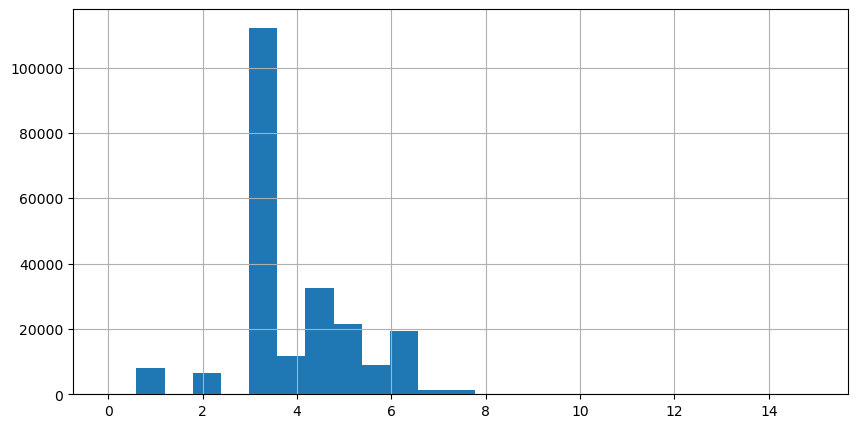

In [11]:
# Now, let's plot the histogram. 
n_bins = 25

plt.figure(figsize=(10,5))
# We can set the number of bins with the *bins* keyword argument.
#plt.scatter(np.arange(len(lengths)),np.log(lengths), marker='.')
plt.hist(np.log(lengths), bins=n_bins)
plt.grid(True)
plt.show()

# Okay, that does not look great at all. 
A lot of nodes have more than 10^(3 to 6) number of events. Which means the timestamp difference varies wildly and plain normalization may not be an option anymore. Therefore, we resort to sinusoidal coding like the original BERT paper. 
# So, the question becomes how do we generate paths now. 
Well, here is another interesting situation. We can subsample the stream of events to generate the paths. But again, the question is now how do we encode the subject information in the path. 

In [12]:
max_time_delta = 0
max_sub_origin =  -1
max_event_stamp = -1
max_sub = -1

min_time_delta = 100000000000000
min_sub_origin =  -1
min_event_stamp = -1
min_sub = -1
negative_count = 0
total_count = 0

for subject in provenance_graph:
    subject_timestamp = provenance_graph[subject]['sub'][2]
    event_list = provenance_graph[subject]['events']
    total_count += len(event_list)
    if subject_timestamp != 0:
        for event in event_list:
            if event[0][3] != 0:
                time_delta = event[0][3] - subject_timestamp

                if time_delta<=0:
                    negative_count +=1 
            
                if time_delta > max_time_delta:    
                    max_time_delta = time_delta
                    max_sub_origin = subject_timestamp
                    max_event_stamp = event[0][3]
                    max_sub = subject

                if time_delta < min_time_delta:
                    min_time_delta = time_delta
                    min_sub_origin = subject_timestamp
                    min_event_stamp = event[0][3]
                    min_sub = subject
        
print("Max time delta: {}, max_sub_origin: {}, max_event_stamp = {}, max_sub = {}".format(max_time_delta, max_sub_origin, max_event_stamp, max_sub))
print("Min time delta: {}, min_sub_origin: {}, min_event_stamp = {}, min_sub = {}".format(min_time_delta, min_sub_origin, min_event_stamp, min_sub))
print("Negative count: {}, pct: {}".format(negative_count, (negative_count/total_count)*100))


Max time delta: 270997933817167, max_sub_origin: 1522759935112293459, max_event_stamp = 1523030933046110626, max_sub = 10623
Min time delta: -10001641, min_sub_origin: 1523218713175536589, min_event_stamp = 1523218713165534948, min_sub = 121235
Negative count: 2819176, pct: 6.827477012164842


### Looks like 6.82% events are have negative time delta which is not possible for us to use. In this case, the ususal approach is to drop the data points. 

In [275]:
cleaned_provenance_graph = dict() # Pruned graph object
remove_count = 0 # Number of events that have been removed from the graph
keep_count = 0 # Number of events that have been retained from the graph

for subject in provenance_graph:
    
    subject_timestamp = provenance_graph[subject]['sub'][2]
    event_list = provenance_graph[subject]['events'] 
    temp_event_list = []
    condition = lambda x: [0,0] if ( x is None) else x
    for event in event_list:
        if event[0][3] != 0:
            time_delta = event[0][3] - subject_timestamp
            if time_delta>0:
                temp_event_list.append(event)
            else:
                remove_count +=1
        else:
            remove_count+=1 

    tuple_event_list = [tuple(condition(x[0])+condition(x[1])+condition(x[2])) for x in temp_event_list]
    tuple_event_list = set(tuple_event_list)
    tuple_event_list = [ [[x[0],x[1],x[2],x[3],x[4]], [x[5],x[6]], [x[7], x[8]]]  for x in tuple_event_list ]
    
    if len(tuple_event_list)>0:
        
        cleaned_provenance_graph[subject] = dict()
        cleaned_provenance_graph[subject]['sub'] = provenance_graph[subject]['sub'] # Saving the subject identity.
        cleaned_provenance_graph[subject]['events'] = tuple_event_list
        keep_count += len(tuple_event_list)

Number of events kept: 10796008, number of events removed for negative time delta: 2819176, percentage: 20.706117522906776


In [281]:
print("Number of events kept: {}, number of events removed for negative time delta: {}, reduced graph size percentage: {}".format(keep_count, remove_count, ((100*keep_count)/41350895)))

Number of events kept: 10796008, number of events removed for negative time delta: 2819176, reduced graph size percentage: 26.108281332242022


In [279]:
for subject in cleaned_provenance_graph:
    if len(cleaned_provenance_graph[subject]['events']) == 0:
        cleaned_provenance_graph.pop(subject,None)

print(len(cleaned_provenance_graph)/len(provenance_graph))

0.9594416139480517


In [280]:
# Running the same code block on the pruned provenance graph
max_time_delta = 0
max_sub_origin =  -1
max_event_stamp = -1
max_sub = -1

min_time_delta = 100000000000000
min_sub_origin =  -1
min_event_stamp = -1
min_sub = -1
negative_count = 0
total_count = 0

for subject in cleaned_provenance_graph:
    subject_timestamp = cleaned_provenance_graph[subject]['sub'][2]
    event_list = cleaned_provenance_graph[subject]['events']
    total_count += len(event_list)
    if subject_timestamp != 0:
        for event in event_list:
            if event[0][3] != 0:
                time_delta = event[0][3] - subject_timestamp

                if time_delta<=0:
                    negative_count +=1 
            
                if time_delta > max_time_delta:    
                    max_time_delta = time_delta
                    max_sub_origin = subject_timestamp
                    max_event_stamp = event[0][3]
                    max_sub = subject

                if time_delta < min_time_delta:
                    min_time_delta = time_delta
                    min_sub_origin = subject_timestamp
                    min_event_stamp = event[0][3]
                    min_sub = subject
        
print("Max time delta: {}, max_sub_origin: {}, max_event_stamp = {}, max_sub = {}".format(max_time_delta, max_sub_origin, max_event_stamp, max_sub))
print("Min time delta: {}, min_sub_origin: {}, min_event_stamp = {}, min_sub = {}".format(min_time_delta, min_sub_origin, min_event_stamp, min_sub))
print("Negative count: {}, pct: {}".format(negative_count, (negative_count/total_count)*100))


Max time delta: 270997933817167, max_sub_origin: 1522759935112293459, max_event_stamp = 1523030933046110626, max_sub = 10623
Min time delta: 1472570, min_sub_origin: 1523556159254718787, min_event_stamp = 1523556159256191357, min_sub = 200097
Negative count: 0, pct: 0.0


In [282]:
MAX_TIME_DELTA = 270997933817167
NUMERATOR = np.pi * 0.5 * (1/MAX_TIME_DELTA)
print(NUMERATOR)
print(np.sin(NUMERATOR*MAX_TIME_DELTA))

5.796340601824141e-15
1.0


# Encoding of a sequence.
The following function handles sampling from teh graph and encoding the sequence

In [283]:
MAX_SUB_ID = 224629
def get_random_sequence(subject_id, encoding = None, sequence_size = 31 , imaging = False):
    
    subject_start_time_stamp = cleaned_provenance_graph[subject_id]['sub'][2]
    events = cleaned_provenance_graph[subject_id]['events']
    sampled_events = None
    
    if len(events)>sequence_size:
        sampled_events = random.sample(events, k=sequence_size)
    else:
        sampled_events = events

    sampled_events = sorted(sampled_events, key=lambda x:x[0][3])

    result_array = None
    index = -1
    
    if imaging:
        result_array = np.zeros((sequence_size*8)+8)
        index = 8
    else:
        result_array = np.zeros((sequence_size*8)+2)
        index = 2
    
    for event in sampled_events:
        temp = np.zeros(8)

        temp[0] = event[0][0] # Normalized event type
        temp[1] = event[0][1] # Normalized predicate object 1 type
        temp[2] = event[0][2] # Normalized predicate object 2 type
        temp[3] = event[0][4] # Normalized event name

        if event[1] is not None:
            temp[4] = event[1][0] # Details of predicate object 1 if available
            temp[5] = event[1][1] 
        if event[2] is not None:
            temp[6] = event[2][0] # Details of predicate object 2 if available
            temp[7] = event[2][1]
        
        
        time_delta = event[0][3] - subject_start_time_stamp 

        if encoding == 'sine':
            result_array[index:index+8] = temp * np.sin(NUMERATOR * time_delta)
        elif encoding == 'cosine':
            result_array[index:index+8] = temp * np.cos(NUMERATOR * time_delta)
        elif encoding =='linear':
            result_array[index:index+8] = temp * (time_delta/MAX_TIME_DELTA)
        elif encoding is None:
            result_array[index:index+8] = temp
        
        index+=8

    result_array[0] = cleaned_provenance_graph[subject_id]['sub'][0]
    result_array[1] = cleaned_provenance_graph[subject_id]['sub'][1]
    if imaging:
        result_array[2] = int(subject_id)/(MAX_SUB_ID+1)
    return result_array

In [284]:
get_random_sequence('74245', encoding=None, imaging=True)

array([ 0.25      ,  0.        ,  0.3305213 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.64      ,  0.41666667,
        0.        ,  0.33333333,  0.5       , -1.        ,  0.        ,
        0.        ,  0.74      ,  0.41666667,  0.        ,  0.26315789,
        1.        ,  0.        ,  0.        ,  0.        ,  0.64      ,
        0.41666667,  0.        ,  0.33333333,  0.5       , -1.        ,
        0.        ,  0.        ,  0.64      ,  0.41666667,  0.        ,
        0.33333333,  0.5       , -1.        ,  0.        ,  0.        ,
        0.74      ,  0.41666667,  0.        ,  0.26315789,  1.        ,
        0.        ,  0.        ,  0.        ,  0.74      ,  0.41666667,
        0.        ,  0.26315789,  1.        ,  0.        ,  0.        ,
        0.        ,  0.74      ,  0.41666667,  0.        ,  0.26315789,
        1.        ,  0.        ,  0.        ,  0.        ,  0.74      ,
        0.41666667,  0.        ,  0.26315789,  1.        ,  0.  

In [285]:
# import traceback

# t_condition = lambda x: [0,0] if ( x is None) else x
# try:
#     uniques = [ t_condition(x[0]) +t_condition(x[1]) +t_condition(x[2]) for x in cleaned_provenance_graph['74189']['events'] ]
#     uniques = [tuple(x) for x in uniques]
#     uniques = set(uniques)
#     uniques = [ [[x[0],x[1],x[2],x[3],x[4]], [x[5],x[6]], [x[7], x[8]]]  for x in uniques]
# except:
#     traceback.print_exc()

In [251]:
len(cleaned_provenance_graph['74189']['events'])

155

In [286]:
subject_list = list(cleaned_provenance_graph.keys())
print(len(subject_list))
random.shuffle(subject_list)

215055


# Generators

In [146]:
def generator( datasource , encoding_scheme = None, batch_size = 32, sequence_size = 31):
    while True:
        x = np.zeros((batch_size, (sequence_size*8)+2))
        y = np.zeros((batch_size, (sequence_size*8)+2))

        subjects = random.sample(datasource, k=batch_size)

        for i in range(batch_size):
            x[i] = get_random_sequence(subjects[i], encoding=encoding_scheme ,sequence_size= sequence_size)
            y[i] = x[i]

        yield x,y

In [287]:
def image_generator(datasource , encoding_scheme = None, batch_size = 32, sequence_size = 31):
    while True:
        x = np.zeros((batch_size, (sequence_size*8)+8))
        subjects = random.sample(datasource, k=batch_size)
        for i in range(batch_size):
            x[i] = get_random_sequence(subjects[i], encoding=encoding_scheme ,sequence_size= sequence_size, imaging=True)

        target = np.reshape(x, (batch_size, (sequence_size+1),8))
        target[:,0,2] /=65535

        yield target, target 

In [288]:
def skip_pixel_image_generator(datasource , encoding_scheme = None, batch_size = 32, sequence_size = 31, skip_pct = 0.2):
    while True:
        x = np.zeros((batch_size, (sequence_size*8)+8))
        subjects = random.sample(datasource, k=batch_size)
        for i in range(batch_size):
            x[i] = get_random_sequence(subjects[i], encoding=encoding_scheme ,sequence_size= sequence_size, imaging=True)

        samples = np.reshape(x, (batch_size, (sequence_size+1),8))
        samples[:,0,2] /=65535
        target = np.copy(samples)

        number_of_skip = int(batch_size*skip_pct)
        skip_indices = random.sample(range(1,batch_size,1), k=number_of_skip)
        for index in skip_indices:
            samples[index] = np.zeros(((sequence_size+1),8))

        yield samples, target 

# Model 1

In [337]:
def get_autoencoder(input_length):
    input_layer = tf.keras.Input(shape=(input_length+1, 8, 1 ))
    
    feature_extraction = tf.keras.layers.Conv2D(128, (1,8), activation='relu')(input_layer)
    flattening = tf.keras.layers.Flatten()(feature_extraction)
    
    layer_0_down = tf.keras.layers.Dense(512, activation ='relu')(flattening)
    dropout0 = tf.keras.layers.Dropout(rate=0.25)(layer_0_down)
    
    layer_1_down = tf.keras.layers.Dense(256, activation ='relu')(dropout0)
    dropout1 = tf.keras.layers.Dropout(rate=0.25)(layer_1_down)
    
    layer_2_down =  tf.keras.layers.Dense(128, activation ='relu')(dropout1)
    
    # layer_3_down = tf.keras.layers.Dense(64, activation ='relu')(layer_2_down)
    
    bottleneck_layer = tf.keras.layers.Dense(128, activation ='relu')(layer_2_down)
    
    # layer_1_up = tf.keras.layers.Dense(64, activation ='relu')(bottleneck_layer)
    
    layer_2_up = tf.keras.layers.Dense(128, activation ='relu')(bottleneck_layer) 
    
    layer_3_up = tf.keras.layers.Dense(256, activation ='relu')(layer_2_up)
    dropout2 = tf.keras.layers.Dropout(rate=0.25)(layer_3_up)
    
    layer_4_up = tf.keras.layers.Dense(512, activation ='relu')(dropout2)
    dropout3 = tf.keras.layers.Dropout(rate=0.25)(layer_4_up)

    layer_5_up = tf.keras.layers.Dense(3072, activation ='relu')(dropout3)
    reshape = tf.keras.layers.Reshape((24,1,128))(layer_5_up)
    
    #output_layer = tf.keras.layers.Dense(input_length, activation ='relu')(reshape)
    output_layer = tf.keras.layers.Conv2DTranspose(1, (1,8), strides=(1,1), activation ='relu')(reshape)

    autoencoder_model = tf.keras.Model(input_layer, output_layer)

    return autoencoder_model

In [357]:
tf.keras.backend.clear_session()

In [358]:
seq_length = 23
autoencoder = get_autoencoder(seq_length)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 8, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 1, 128)        1152      
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0     

In [359]:
total_dataset_length = 224146

validation_length = 60000
training_length = total_dataset_length-validation_length


training_data = subject_list[:training_length]
validation_data = subject_list[training_length:]

train_seq_generator = image_generator(training_data, encoding_scheme= 'sine', batch_size=128, sequence_size=23)
valid_seq_generator = image_generator(validation_data, encoding_scheme='sine', batch_size=128, sequence_size=23)

In [360]:
autoencoder.compile(loss=tf.keras.losses.MSE , optimizer=tf.keras.optimizers.Adam(learning_rate=5e-04))

In [361]:
history = autoencoder.fit_generator(train_seq_generator, steps_per_epoch=1000, epochs = 10, validation_data = valid_seq_generator, validation_steps=250)

/home/monowar/anaconda3/envs/envphase2/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1000/1000 [==============================] - 26s 26ms/step - loss: 1449.7998 - val_loss: 205.4621
Epoch 2/10
1000/1000 [==============================] - 25s 25ms/step - loss: 156.9663 - val_loss: 135.9453
Epoch 3/10
1000/1000 [==============================] - 26s 26ms/step - loss: 162.7905 - val_loss: 148.7082
Epoch 4/10
1000/1000 [==============================] - 26s 26ms/step - loss: 554.9325 - val_loss: 59.2964
Epoch 5/10
1000/1000 [==============================] - 26s 26ms/step - loss: 77.1823 - val_loss: 554.8632
Epoch 6/10
1000/1000 [==============================] - 27s 27ms/step - loss: 78.1240 - val_loss: 824.1027
Epoch 7/10
1000/1000 [==============================] - 26s 26ms/step - loss: 228.8014 - val_loss: 101.4425
Epoch 8/10
1000/1000 [==============================] - 27s 27ms/step - loss: 312.2745 - val_loss: 44.1707
Epoch 9/10
1000/1000 [==============================] - 26s 26ms/step - loss: 130.4138 - val_loss: 1626.3037
Epoch 10/10
1000/1000 [=======

In [345]:
training_loss = history.history['loss'][:]
val_los = history.history['val_loss'][:]

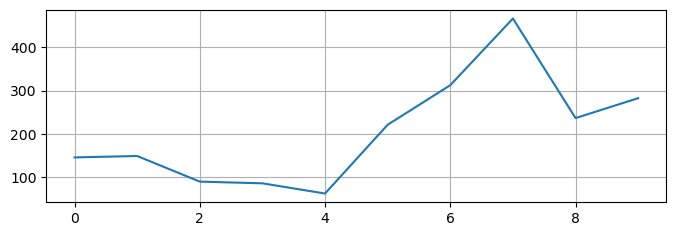

In [346]:
plt.figure(figsize=(8,2.5))
plt.grid()
plt.plot((training_loss))
# plt.plot(np.log(val_los))

plt.show()

# Model 2

In [347]:
def get_conv_autoencoder(sequence_size):
    # Encoder
    input_layer = tf.keras.layers.Input(shape=((sequence_size+1),8,1)) 
    feature_extractor = tf.keras.layers.Conv2D(256, (1,8), activation='relu')(input_layer) # out: (seq_size, 1 , 256) 
    pooling1 = tf.keras.layers.MaxPooling2D((2,1), padding= 'same')(feature_extractor) # out : (seq_size/2, 1, 256)
    conv_0_down = tf.keras.layers.Conv2D(128, (4,1), activation='relu')(pooling1) # out: (seq_size/2 - 3, 1 , 128)
    pooling2 = tf.keras.layers.MaxPooling2D((2,1), padding= 'same')(conv_0_down) # out: ((seq_size/2 - 3)/2, 1 , 128)
    #Decoder
    conv_0_up = tf.keras.layers.Conv2DTranspose(128, (4,1), strides=(2,1), activation='relu', output_padding=(1,0))(pooling2)
    conv_1_up = tf.keras.layers.Conv2DTranspose(256, (2,8), strides=(2,1), activation='relu', output_padding=(0,0))(conv_0_up)
    output_layer = tf.keras.layers.Conv2D(1, (1,1), activation = 'relu')(conv_1_up)

    conv_autoencoder = tf.keras.Model(input_layer, output_layer)

    return conv_autoencoder

In [348]:
def get_conv_autoencoder_no_pooling(sequence_size):
    input_layer = tf.keras.layers.Input(shape=((sequence_size+1),8,1)) 
    feature_extractor = tf.keras.layers.Conv2D(256, (1,8), activation='relu')(input_layer) # out: (seq_size, 1 , 256)
    
    down_sample1 = tf.keras.layers.Conv2D(64, (11,1), activation= 'relu')(feature_extractor)
    down_sample2 = tf.keras.layers.Conv2D(32, (11,1), activation= 'relu')(down_sample1)
    
    bottleneck = tf.keras.layers.Conv2D(16, (21,1), activation='relu')(down_sample2)

    up_sample1 = tf.keras.layers.Conv2DTranspose(32, (21,1), strides=(1,1), activation='relu', output_padding=(0,0))(bottleneck)
    up_sample2 = tf.keras.layers.Conv2DTranspose(64, (11,1), strides=(1,1), activation='relu', output_padding=(0,0))(up_sample1)
    up_sample3 = tf.keras.layers.Conv2DTranspose(256, (11,8), strides=(1,1), activation='relu', output_padding=(0,0))(up_sample2)

    reconstruction = tf.keras.layers.Conv2D(1, (1,1), activation='relu')(up_sample3)

    conv_no_pool_autoenecoder = tf.keras.Model(input_layer, reconstruction)

    return conv_no_pool_autoenecoder

In [349]:
total_dataset_length = 224146

validation_length = 60000
training_length = total_dataset_length-validation_length


training_data = subject_list[:training_length]
validation_data = subject_list[training_length:]

train_seq_generator_conv = image_generator(training_data, encoding_scheme= None, batch_size=128, sequence_size=69)
valid_seq_generator_conv = image_generator(validation_data, encoding_scheme=None, batch_size=128, sequence_size=69)

In [350]:
tf.keras.backend.clear_session()

In [351]:
conv_based_autoencoder = get_conv_autoencoder(69)
#conv_based_autoencoder = get_conv_autoencoder_no_pooling(63)
conv_based_autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70, 8, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 70, 1, 256)        2304      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 1, 256)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 1, 128)        131200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 1, 128)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 35, 1, 128)        65664     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 70, 8, 256)        524544

In [352]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [76]:
def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

In [353]:
conv_based_autoencoder.compile(loss=tf.keras.losses.MSE, optimizer=tf.keras.optimizers.Adam(learning_rate=5e-04))
#conv_based_autoencoder.compile(loss=tf.keras.losses.MSE, optimizer=tf.keras.optimizers.Adam(learning_rate=5e-04))

In [354]:
history = conv_based_autoencoder.fit_generator(train_seq_generator_conv, steps_per_epoch=500, epochs=50, validation_data = valid_seq_generator_conv, validation_steps=250)

/home/monowar/anaconda3/envs/envphase2/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
500/500 [==============================] - 20s 39ms/step - loss: 412.5180 - val_loss: 0.0640
Epoch 2/50
500/500 [==============================] - 19s 39ms/step - loss: 0.0842 - val_loss: 0.0433
Epoch 3/50
500/500 [==============================] - 19s 39ms/step - loss: 0.0464 - val_loss: 0.0429
Epoch 4/50
500/500 [==============================] - 20s 39ms/step - loss: 0.0425 - val_loss: 0.0457
Epoch 5/50
500/500 [==============================] - 19s 39ms/step - loss: 0.0461 - val_loss: 0.0837
Epoch 6/50
500/500 [==============================] - 19s 38ms/step - loss: 0.3967 - val_loss: 0.0400
Epoch 7/50
500/500 [==============================] - 19s 38ms/step - loss: 4.1701 - val_loss: 0.0441
Epoch 8/50
500/500 [==============================] - 19s 39ms/step - loss: 0.1069 - val_loss: 0.0416
Epoch 9/50
500/500 [==============================] - 19s 39ms/step - loss: 0.1685 - val_loss: 0.0707
Epoch 10/50
500/500 [==============================] - 19s 39ms/step - loss: 0.0

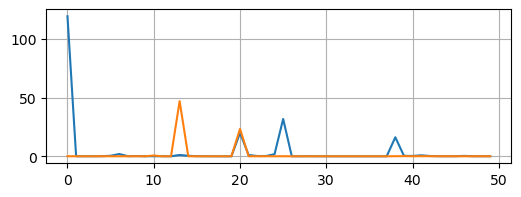

In [356]:
training_loss = history.history['loss'][:]
val_los = history.history['val_loss'][:]

plt.figure(figsize=(6,2))
plt.grid()

plt.plot((training_loss))
plt.plot((val_los))

plt.show()

## Before we proceed any further, let us process the labeled data. We have two files for that. Let us extract them and create a label holder.

In [97]:
file_event_labels = '/mnt/8tb/csenrc/representation_learning_codes/File_events_labels.csv'
network_event_labels = '/mnt/8tb/csenrc/representation_learning_codes/IP_events_labels.csv'

In [98]:
malicious_file_events = pd.read_csv(file_event_labels)
malicious_ip_events = pd.read_csv(network_event_labels)

In [99]:
malicious_file_events.head()

,event_uuid,event_name,event_type,time_stamp_nanos,subject_uuid,predicate_object,prediacte_object_path,predicate_object_2,predicate_object_path_2
0,7DBB1800-D1DD-5300-9D44-1A13E9981557,aue_open_rwtc,EVENT_OPEN,1523625074974644925,11C65665-3DC3-11E8-A5CA-3FA3753A265A,0C773AFD-8F2A-3555-AA8F-AFF835357207,/tmp/eWq10bVcx,NaN,NaN
1,484BEB8C-FA55-54C0-BC5B-0BA0CCA84818,aue_chmod,EVENT_MODIFY_FILE_ATTRIBUTES,1523625074974644925,11C65665-3DC3-11E8-A5CA-3FA3753A265A,0C773AFD-8F2A-3555-AA8F-AFF835357207,/tmp/eWq10bVcx,NaN,NaN
2,401ECBFF-F199-5CB7-BB3F-33421209E979,aue_open_rwtc,EVENT_OPEN,1523625384084637086,4FB0BFEA-3F1C-11E8-A5CB-3FA3753A265A,0C773AFD-8F2A-3555-AA8F-AFF835357207,/tmp/eWq10bVcx,NaN,NaN
3,C069C841-DBAF-5D41-BA83-17B97B6B8108,aue_openat_rwtc,EVENT_OPEN,1523625386674637936,2CA83801-3E80-11E8-A5CB-3FA3753A265A,0C773AFD-8F2A-3555-AA8F-AFF835357207,/tmp/eWq10bVcx,NaN,NaN
4,B6316F5A-21F9-53DB-986F-E993F7FF778C,aue_openat_rwtc,EVENT_OPEN,1523625429714638405,4FB0BFEA-3F1C-11E8-A5CB-3FA3753A265A,0C773AFD-8F2A-3555-AA8F-AFF835357207,/tmp/eWq10bVcx,NaN,NaN


In [101]:
print(len(malicious_file_events))
print(len(malicious_file_events['subject_uuid'].unique()))

93
27


In [102]:
malicious_file_subjects = malicious_file_events['subject_uuid'].unique()

In [103]:
# Setting up a db connection. I was trying to avoid this. But, well. It is what it is.

psql_connection_url = 'postgresql+psycopg2://csephase2:csephase@@localhost/darpa_tc3'
psql_engine = create_engine(psql_connection_url)
Session = sessionmaker(bind=psql_engine)
session = Session()

In [107]:
for subject in malicious_file_subjects:
    sub = gc.get_node(session, subject, gc.mapping_dict["SUBJECT"])
    print(sub.uuid," has database primary key : ", sub.id, " and currently has : ", len(cleaned_provenance_graph[str(sub.id)]['events']), " events in the graph.")

11C65665-3DC3-11E8-A5CA-3FA3753A265A  has database primary key :  201998  and currently has :  546  events in the graph.
4FB0BFEA-3F1C-11E8-A5CB-3FA3753A265A  has database primary key :  216121  and currently has :  20799  events in the graph.
2CA83801-3E80-11E8-A5CB-3FA3753A265A  has database primary key :  200770  and currently has :  662  events in the graph.
E0C1A46B-3F1B-11E8-A5CB-3FA3753A265A  has database primary key :  216033  and currently has :  276  events in the graph.
042ADADF-3F1C-11E8-A5CB-3FA3753A265A  has database primary key :  216056  and currently has :  275  events in the graph.
8603F11E-3F1C-11E8-A5CB-3FA3753A265A  has database primary key :  216144  and currently has :  290  events in the graph.
E24D97B4-3F1C-11E8-A5CB-3FA3753A265A  has database primary key :  216180  and currently has :  279  events in the graph.
0A5AA28E-3F1D-11E8-A5CB-3FA3753A265A  has database primary key :  216199  and currently has :  289  events in the graph.
11AA4698-3F1D-11E8-A5CB-3FA375

In [3]:
dir = '/mnt/8tb/csenrc/tc3/data/trace/extracted_json/'
files = os.listdir('/mnt/8tb/csenrc/tc3/data/trace/extracted_json')
files = [dir+x for x in files]
files

['/mnt/8tb/csenrc/tc3/data/trace/extracted_json/ta1-trace-e3-official.json.78',
 '/mnt/8tb/csenrc/tc3/data/trace/extracted_json/ta1-trace-e3-official.json.147',
 '/mnt/8tb/csenrc/tc3/data/trace/extracted_json/ta1-trace-e3-official.json.114',
 '/mnt/8tb/csenrc/tc3/data/trace/extracted_json/ta1-trace-e3-official.json.92',
 '/mnt/8tb/csenrc/tc3/data/trace/extracted_json/ta1-trace-e3-official.json.103',
 '/mnt/8tb/csenrc/tc3/data/trace/extracted_json/ta1-trace-e3-official.json.128',
 '/mnt/8tb/csenrc/tc3/data/trace/extracted_json/ta1-trace-e3-official.json.186',
 '/mnt/8tb/csenrc/tc3/data/trace/extracted_json/ta1-trace-e3-official.json.66',
 '/mnt/8tb/csenrc/tc3/data/trace/extracted_json/ta1-trace-e3-official.json.47',
 '/mnt/8tb/csenrc/tc3/data/trace/extracted_json/ta1-trace-e3-official.json.169',
 '/mnt/8tb/csenrc/tc3/data/trace/extracted_json/ta1-trace-e3-official.json.155',
 '/mnt/8tb/csenrc/tc3/data/trace/extracted_json/ta1-trace-e3-official.json.67',
 '/mnt/8tb/csenrc/tc3/data/trace/